In [80]:
#import libraries
from datetime import datetime
import numpy as np             #for numerical computations like log,exp,sqrt etc
import pandas as pd            #for reading & storing data, pre-processing
import matplotlib.pylab as plt #for visualization
#for making sure matplotlib plots are generated in Jupyter notebook itself
%matplotlib inline             
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from datetime import timedelta
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import os
import math
import numpy
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

In [81]:
#read data
dataset = pd.read_csv('Book1.csv')
#Parse strings to datetime type
dataset['date'] = pd.to_datetime(dataset['date'],infer_datetime_format=True) #convert from string to datetime
indexedDataset = dataset.set_index(['date'])
indexedDataset.head(5)


,open
date,
2001-01-03,210.56
2001-01-05,214.32
2001-01-08,218.12
2001-01-10,222.15
2001-01-12,225.67


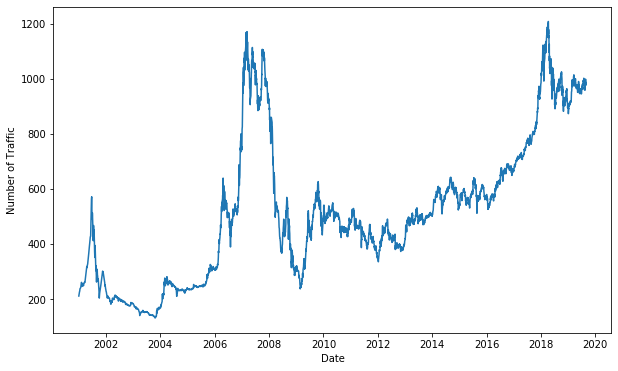

In [82]:
plt.xlabel('Date')
plt.ylabel('Number of Traffic')
plt.plot(indexedDataset)

In [83]:
#Determine rolling statistics
rolmean = indexedDataset.rolling(window=12).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
rolstd = indexedDataset.rolling(window=12).std()
print(rolmean,rolstd)

                  open
date                  
2001-01-03         NaN
2001-01-05         NaN
2001-01-08         NaN
2001-01-10         NaN
2001-01-12         NaN
2001-01-15         NaN
2001-01-17         NaN
2001-01-19         NaN
2001-01-29         NaN
2001-01-31         NaN
2001-02-02         NaN
2001-02-05  231.764167
2001-02-07  235.878333
2001-02-09  239.697500
2001-02-12  242.869167
2001-02-14  245.374167
2001-02-16  247.316667
2001-02-19  248.786667
2001-02-21  249.959167
2001-02-23  251.146667
2001-02-26  252.334167
2001-02-28  252.884167
2001-03-02  253.168333
2001-03-05  252.815833
2001-03-07  251.825833
2001-03-09  251.197500
2001-03-12  251.181667
2001-03-14  251.639167
2001-03-16  252.434167
2001-03-19  253.625833
...                ...
2019-07-22  975.801667
2019-07-23  976.521667
2019-07-24  978.203333
2019-07-25  980.004167
2019-07-26  981.971667
2019-07-29  983.411667
2019-07-30  985.190833
2019-07-31  986.060000
2019-08-01  987.576667
2019-08-02  988.081667
2019-08-05 

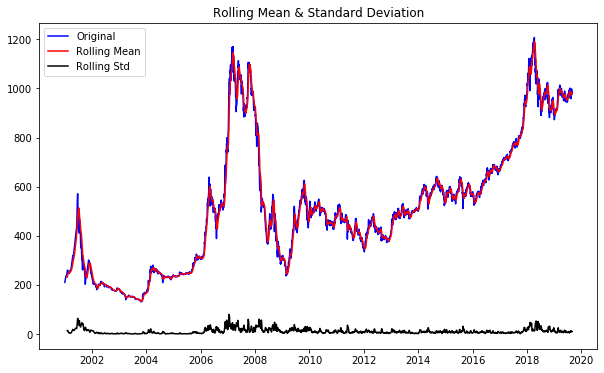

In [84]:
#Plot rolling statistics
orig = plt.plot(indexedDataset, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [85]:
#Perform Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(indexedDataset['open'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                   -1.665342
p-value                           0.449052
#Lags Used                       27.000000
Number of Observations Used    4510.000000
Critical Value (1%)              -3.431801
Critical Value (5%)              -2.862181
Critical Value (10%)             -2.567111
dtype: float64


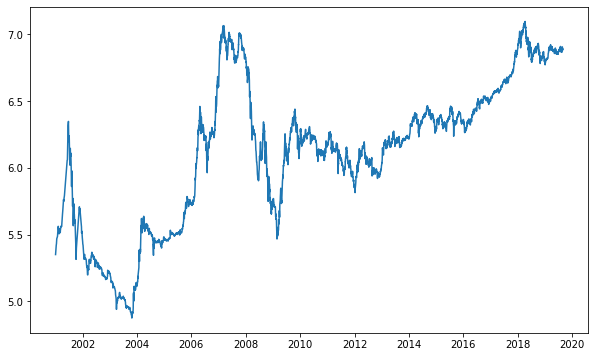

In [86]:
#log scale transformation
#Estimating trend
indexedDataset_logScale = np.log(indexedDataset)
plt.plot(indexedDataset_logScale)

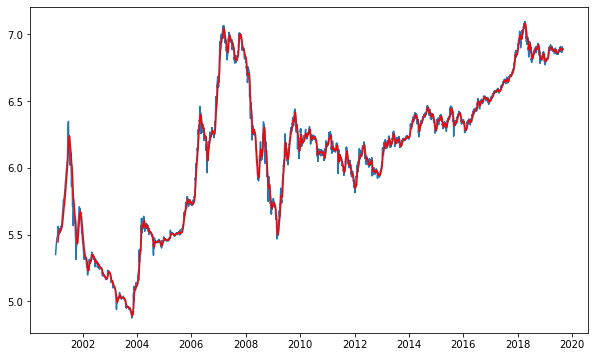

In [87]:
#The below transformation is required to make series stationary
movingAverage = indexedDataset_logScale.rolling(window=12).mean()
movingSTD = indexedDataset_logScale.rolling(window=12).std()
plt.plot(indexedDataset_logScale)
plt.plot(movingAverage, color='red')

In [88]:
datasetLogScaleMinusMovingAverage = indexedDataset_logScale - movingAverage
datasetLogScaleMinusMovingAverage.head(12)

#Remove NAN values
datasetLogScaleMinusMovingAverage.dropna(inplace=True)
datasetLogScaleMinusMovingAverage.head(10)

,open
date,
2001-02-05,0.097150
2001-02-07,0.098902
2001-02-09,0.083599
2001-02-12,0.054818
2001-02-14,0.028624
2001-02-16,0.007543
2001-02-19,-0.010740
2001-02-21,-0.012548
2001-02-23,0.000539


In [89]:
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries['open'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)


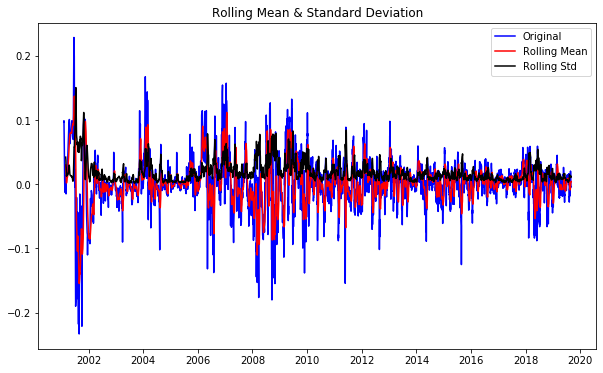

Results of Dickey Fuller Test:
Test Statistic                -1.225021e+01
p-value                        9.578700e-23
#Lags Used                     1.100000e+01
Number of Observations Used    4.515000e+03
Critical Value (1%)           -3.431799e+00
Critical Value (5%)           -2.862180e+00
Critical Value (10%)          -2.567111e+00
dtype: float64


In [90]:
test_stationarity(datasetLogScaleMinusMovingAverage)

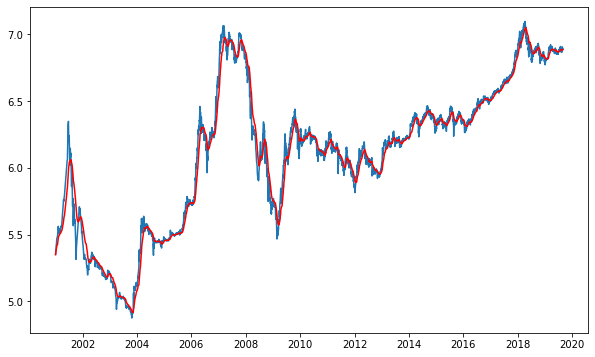

In [91]:
#Exponential Decay Transformation 
exponentialDecayWeightedAverage = indexedDataset_logScale.ewm(halflife=12, min_periods=0, adjust=True).mean()
plt.plot(indexedDataset_logScale)
plt.plot(exponentialDecayWeightedAverage, color='red')

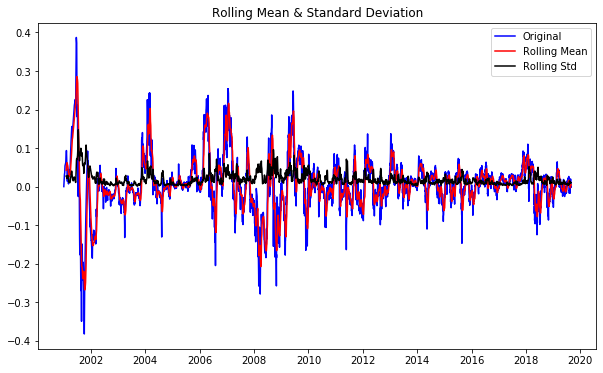

Results of Dickey Fuller Test:
Test Statistic                -8.958835e+00
p-value                        8.330794e-15
#Lags Used                     5.000000e+00
Number of Observations Used    4.532000e+03
Critical Value (1%)           -3.431794e+00
Critical Value (5%)           -2.862178e+00
Critical Value (10%)          -2.567110e+00
dtype: float64


In [92]:
datasetLogScaleMinusExponentialMovingAverage = indexedDataset_logScale - exponentialDecayWeightedAverage
test_stationarity(datasetLogScaleMinusExponentialMovingAverage)

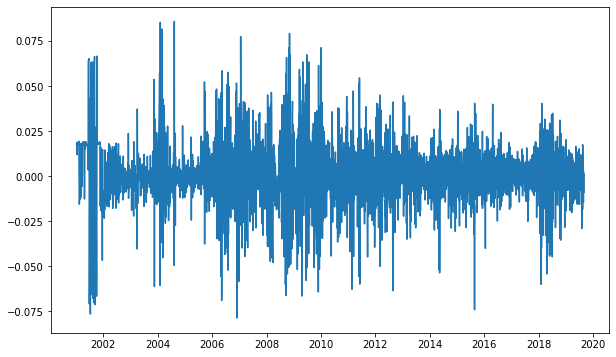

In [93]:
#Time Shift Transformation
datasetLogDiffShifting = indexedDataset_logScale - indexedDataset_logScale.shift()
plt.plot(datasetLogDiffShifting)

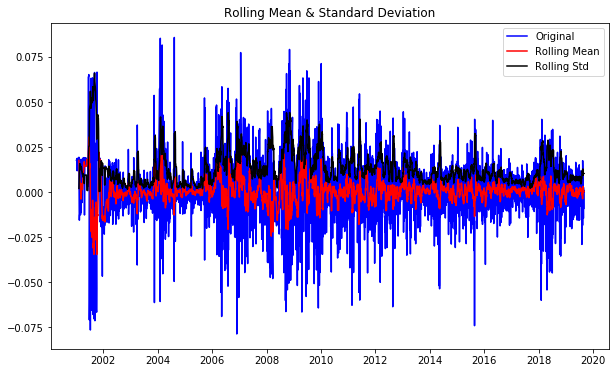

Results of Dickey Fuller Test:
Test Statistic                -1.447229e+01
p-value                        6.575216e-27
#Lags Used                     1.400000e+01
Number of Observations Used    4.522000e+03
Critical Value (1%)           -3.431797e+00
Critical Value (5%)           -2.862179e+00
Critical Value (10%)          -2.567110e+00
dtype: float64


In [94]:
datasetLogDiffShifting.dropna(inplace=True)
test_stationarity(datasetLogDiffShifting)

In [95]:
decomposition = seasonal_decompose(indexedDataset_logScale) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(indexedDataset_logScale, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(411)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(411)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()
decomposedLogData = residual
decomposedLogData.dropna(inplace=True)
test_stationarity(decomposedLogData)

ValueError: You must specify a freq or x must be a pandas object with a timeseries index with a freq not set to None

In [96]:
decomposedLogData = residual
decomposedLogData.dropna(inplace=True)
test_stationarity(decomposedLogData)

NameError: name 'residual' is not defined

C:\Users\T560\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


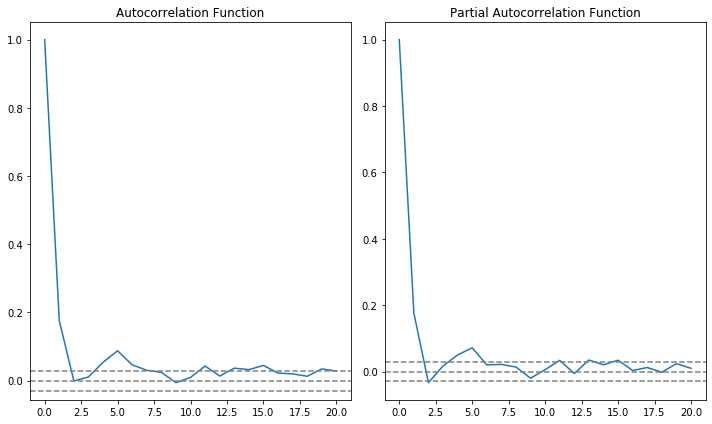

In [97]:
#Plotting ACF and PACF
#ACF & PACF plots

lag_acf = acf(datasetLogDiffShifting, nlags=20)
lag_pacf = pacf(datasetLogDiffShifting, nlags=20, method='ols')

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')            

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
            
plt.tight_layout()            

C:\Users\T560\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\T560\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Plotting AR model


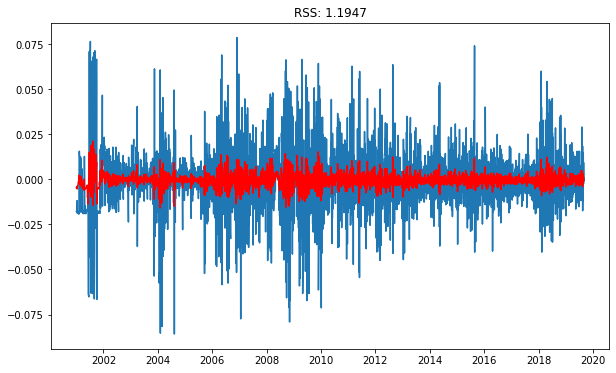

In [59]:
#AR Model
#making order=(5,1,0) gives RSS=1.5023
model = ARIMA(indexedDataset_logScale, order=(5,1,0))
results_AR = model.fit(disp=-1)
plt.plot(datasetLogDiffShifting)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_AR.fittedvalues - datasetLogDiffShifting['open'])**2))
print('Plotting AR model')

C:\Users\T560\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\T560\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Plotting MA model


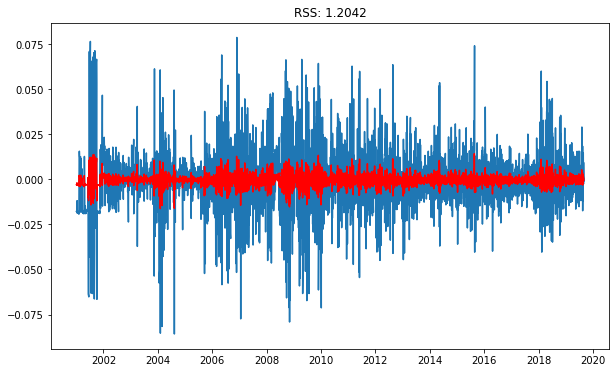

In [61]:
#MA Model
model = ARIMA(indexedDataset_logScale, order=(0,1,2))
results_MA = model.fit(disp=-1)
plt.plot(datasetLogDiffShifting)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_MA.fittedvalues - datasetLogDiffShifting['open'])**2))
print('Plotting MA model')

C:\Users\T560\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\T560\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Plotting ARIMA model


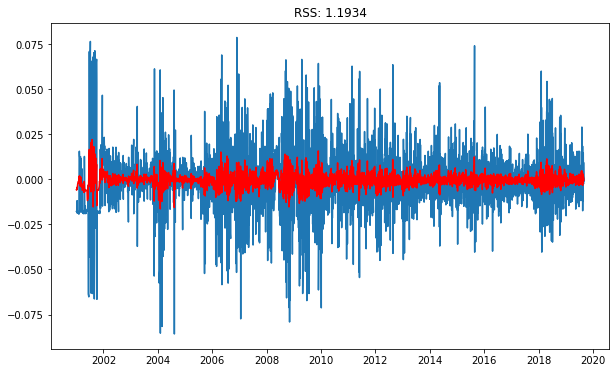

In [63]:
# AR+I+MA = ARIMA model
model = ARIMA(indexedDataset_logScale, order=(5,1,2))
results_ARIMA = model.fit(disp=-1)
plt.plot(datasetLogDiffShifting)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_ARIMA.fittedvalues - datasetLogDiffShifting['open'])**2))
print('Plotting ARIMA model')

In [64]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)

print(datasetLogDiffShifting)

                open
date                
2019-08-29  0.000000
2019-08-28 -0.001094
2019-08-27  0.009402
2019-08-26 -0.002568
2019-08-23  0.014541
2019-08-22 -0.001805
2019-08-21 -0.012167
2019-08-20 -0.000427
2019-08-19  0.000102
2019-08-16 -0.009352
2019-08-15 -0.017414
2019-08-14  0.018440
2019-08-13 -0.003264
2019-08-12  0.002751
2019-08-09  0.001055
2019-08-08 -0.011112
2019-08-07  0.001614
2019-08-06 -0.007149
2019-08-05  0.029054
2019-08-02 -0.001063
2019-08-01  0.005755
2019-07-31 -0.007326
2019-07-30  0.015558
2019-07-29 -0.007246
2019-07-26  0.000573
2019-07-25 -0.008024
2019-07-24  0.006223
2019-07-23 -0.011781
2019-07-22 -0.000214
2019-07-19 -0.003113
...              ...
2001-03-19 -0.003145
2001-03-16 -0.006823
2001-03-14 -0.003177
2001-03-12 -0.006658
2001-03-09 -0.013292
2001-03-07 -0.018216
2001-03-05  0.010746
2001-03-02  0.011539
2001-02-28 -0.004901
2001-02-26  0.012638
2001-02-23 -0.017324
2001-02-21 -0.017953
2001-02-19 -0.003085
2001-02-16  0.012082
2001-02-14  0

In [65]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum)

date
2019-08-29   -0.000344
2019-08-28   -0.000628
2019-08-27   -0.001121
2019-08-26    0.000351
2019-08-23   -0.000723
2019-08-22    0.001774
2019-08-21    0.000934
2019-08-20   -0.000759
2019-08-19   -0.000089
2019-08-16    0.000638
2019-08-15   -0.001451
2019-08-14   -0.004784
2019-08-13   -0.001334
2019-08-12   -0.003471
2019-08-09   -0.004217
2019-08-08   -0.005108
2019-08-07   -0.006893
2019-08-06   -0.006685
2019-08-05   -0.008026
2019-08-02   -0.003246
2019-08-01   -0.005377
2019-07-31   -0.004682
2019-07-30   -0.006064
2019-07-29   -0.001655
2019-07-26   -0.003324
2019-07-25   -0.002359
2019-07-24   -0.003695
2019-07-23   -0.001579
2019-07-22   -0.004318
2019-07-19   -0.004029
                ...   
2001-03-19   -1.467014
2001-03-16   -1.471244
2001-03-14   -1.475175
2001-03-12   -1.477124
2001-03-09   -1.479349
2001-03-07   -1.482716
2001-03-05   -1.486656
2001-03-02   -1.485320
2001-02-28   -1.485399
2001-02-26   -1.488758
2001-02-23   -1.487892
2001-02-21   -1.491521
2001-0

In [66]:
predictions_ARIMA_log = pd.Series(indexedDataset_logScale['open'].iloc[0], index=indexedDataset_logScale.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.head()

date
2001-01-03    5.352575
2001-01-05    5.358265
2001-01-08    5.364266
2001-01-10    5.369867
2001-01-12    5.374282
dtype: float64

In [67]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)

In [68]:
indexedDataset_logScale

,open
date,
2019-08-30,6.885683
2019-08-29,6.885683
2019-08-28,6.884589
2019-08-27,6.893991
2019-08-26,6.891423
2019-08-23,6.905964
2019-08-22,6.904159
2019-08-21,6.891992
2019-08-20,6.891565


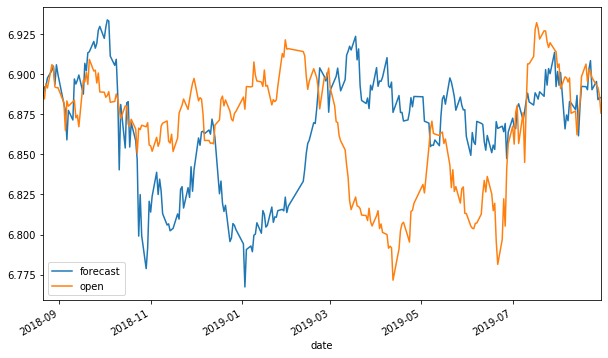

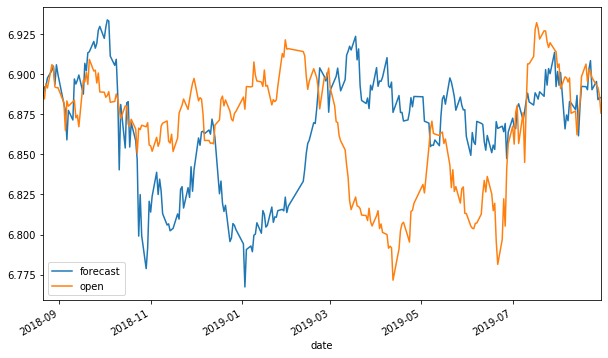

In [69]:

results_ARIMA.plot_predict(1,256) 
#x=results_ARIMA.forecast(steps=120)

In [98]:
#LSTM
def create_dataset(data_series, look_back, split_frac, transforms):
    
    # log transforming that data, if necessary
    if transforms[0] == True:
        dates = data_series.index
        data_series = pd.Series(np.log(data_series), index=dates)
    
    # differencing data, if necessary
    if transforms[1] == True:
        dates = data_series.index
        data_series = pd.Series(data_series - data_series.shift(1), index=dates).dropna()

    # scaling values between 0 and 1
    dates = data_series.index
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data_series.values.reshape(-1, 1))
    data_series = pd.Series(scaled_data[:, 0], index=dates)
    
    # creating targets and features by shifting values by 'i' number of time periods
    df = pd.DataFrame()
    for i in range(look_back+1):
        label = ''.join(['t-', str(i)])
        df[label] = data_series.shift(i)
    df = df.dropna()
    print(df.tail())
    
    # splitting data into train and test sets
    size = int(split_frac*df.shape[0])
    train = df[:size]
    test = df[size:]
    
    # creating target and features for training set
    X_train = train.iloc[:, 1:].values
    y_train = train.iloc[:, 0].values
    train_dates = train.index
    
    # creating target and features for test set
    X_test = test.iloc[:, 1:].values
    y_test = test.iloc[:, 0].values
    test_dates = test.index
    
    # reshaping data into 3 dimensions for modeling with the LSTM neural net
    X_train = np.reshape(X_train, (X_train.shape[0], 1, look_back))
    X_test = np.reshape(X_test, (X_test.shape[0], 1, look_back))
    
    return X_train, y_train, X_test, y_test, train_dates, test_dates, scaler

In [99]:
def inverse_transforms(train_predict, y_train, test_predict, y_test, data_series, train_dates, test_dates, scaler):
    
    # inverse 0 to 1 scaling
    train_predict = pd.Series(scaler.inverse_transform(train_predict.reshape(-1,1))[:,0], index=train_dates)
    y_train = pd.Series(scaler.inverse_transform(y_train.reshape(-1, 1))[:,0], index=train_dates)

    test_predict = pd.Series(scaler.inverse_transform(test_predict.reshape(-1, 1))[:,0], index=test_dates)
    y_test = pd.Series(scaler.inverse_transform(y_test.reshape(-1, 1))[:,0], index=test_dates)
    
    # reversing differencing if log transformed as well
    if (transforms[1] == True) & (transforms[0] == True):
        train_predict = pd.Series(train_predict + np.log(data_series.shift(1)), index=train_dates).dropna()
        y_train = pd.Series(y_train + np.log(data_series.shift(1)), index=train_dates).dropna()

        test_predict = pd.Series(test_predict + np.log(data_series.shift(1)), index=test_dates).dropna()
        y_test = pd.Series(y_test + np.log(data_series.shift(1)), index=test_dates).dropna()
    
    # reversing differencing if no log transform
    elif transforms[1] == True:
        train_predict = pd.Series(train_predict + data_series.shift(1), index=train_dates).dropna()
        y_train = pd.Series(y_train + data_series.shift(1), index=train_dates).dropna()

        test_predict = pd.Series(test_predict + data_series.shift(1), index=test_dates).dropna()
        y_test = pd.Series(y_test + data_series.shift(1), index=test_dates).dropna()
      
    # reversing log transformation
    if transforms[0] == True:
        train_predict = pd.Series(np.exp(train_predict), index=train_dates)
        y_train = pd.Series(np.exp(y_train), index=train_dates)

        test_predict = pd.Series(np.exp(test_predict), index=test_dates)
        y_test = pd.Series(np.exp(y_test), index=test_dates)
        
    return train_predict, y_train, test_predict, y_test

In [100]:

def lstm_model(data_series, look_back, split, transforms, lstm_params):
    np.random.seed(1)
    
    # creating the training and testing datasets
    X_train, y_train, X_test, y_test, train_dates, test_dates, scaler = create_dataset(data_series, look_back, split, transforms)

    # training the model
    model = Sequential()
    model.add(LSTM(lstm_params[0], input_shape=(1, look_back)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, y_train, epochs=lstm_params[1], batch_size=1, verbose=lstm_params[2])
    
    # making predictions
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)
    
    # inverse transforming results
    train_predict, y_train, test_predict, y_test = \
    inverse_transforms(train_predict, y_train, test_predict, y_test, data_series, train_dates, test_dates, scaler)
    
    # plot of predictions and actual values
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(y_test[1:100])
    plt.plot(test_predict[1:100], color='red')
    plt.xlabel("Time")
    plt.ylabel("Traffic")
    plt.title("Forecasting")
    plt.show()
    
    # calculating RMSE metrics
    error = np.sqrt(mean_squared_error(train_predict, y_train))
    print('Train RMSE: %.3f' % error)
    error = np.sqrt(mean_squared_error(test_predict, y_test))
    print('Test RMSE: %.3f' % error)
    error=np.mean(np.abs((y_test - test_predict) / y_test)) * 100
    print('Test MAPE: %.3f' % error)
    
    
    return train_predict, y_train, test_predict, y_test

                 t-0       t-1
date                          
2019-08-26  0.390273  0.489603
2019-08-27  0.494242  0.390273
2019-08-28  0.421502  0.494242
2019-08-29  0.485286  0.421502
2019-08-30  0.478635  0.485286
Epoch 1/5
3175/3175 [==============================] - 22s 7ms/step - loss: 0.0154
Epoch 2/5
3175/3175 [==============================] - 19s 6ms/step - loss: 0.0120
Epoch 3/5
3175/3175 [==============================] - 20s 6ms/step - loss: 0.0120: 0s - 
Epoch 4/5
3175/3175 [==============================] - 20s 6ms/step - loss: 0.0120
Epoch 5/5
3175/3175 [==============================] - 21s 7ms/step - loss: 0.0119


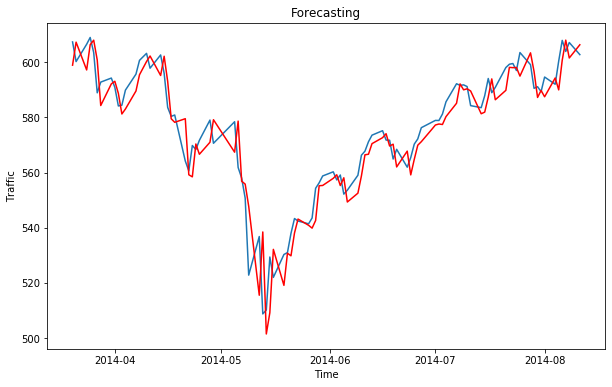

Train RMSE: 9.031
Test RMSE: 10.011
Test MAPE: 0.903


In [101]:
data = pd.Series(pd.read_csv('Book1.csv',  parse_dates=['date'], index_col="date").iloc[:,0]).astype(float)

look_back = 1
split = 0.7
log = True
difference = True
transforms = [log, difference]

nodes = 4
epochs = 5
verbose =1 # 0=print no output, 1=most, 2=less, 3=least
lstm_params = [nodes, epochs, verbose]

lstm_params = [nodes, epochs, verbose]

train_predict, y_train, test_predict, y_test = lstm_model(data, look_back, split, transforms, lstm_params)


In [102]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=9):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

# load the dataset
dataframe = pd.read_csv('Book1.csv',usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')
# split into train and test sets
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape dataset
look_back = 9
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
print(trainX)

[[210.56 214.32 218.12 ... 232.68 236.97 241.36]
 [214.32 218.12 222.15 ... 236.97 241.36 245.8 ]
 [218.12 222.15 225.67 ... 241.36 245.8  250.23]
 ...
 [587.82 586.12 586.65 ... 579.4  580.84 585.1 ]
 [586.12 586.65 569.34 ... 580.84 585.1  590.94]
 [586.65 569.34 569.97 ... 585.1  590.94 590.83]]


Epoch 1/20
 - 5s - loss: 967.9335
Epoch 2/20
 - 3s - loss: 395.5584
Epoch 3/20
 - 3s - loss: 478.9416
Epoch 4/20
 - 3s - loss: 318.8794
Epoch 5/20
 - 3s - loss: 292.7714
Epoch 6/20
 - 3s - loss: 290.6666
Epoch 7/20
 - 3s - loss: 297.8798
Epoch 8/20
 - 3s - loss: 260.7442
Epoch 9/20
 - 3s - loss: 241.0579
Epoch 10/20
 - 4s - loss: 210.6221
Epoch 11/20
 - 4s - loss: 204.8858
Epoch 12/20
 - 3s - loss: 227.9586
Epoch 13/20
 - 3s - loss: 199.4132
Epoch 14/20
 - 3s - loss: 183.2316
Epoch 15/20
 - 3s - loss: 201.6805
Epoch 16/20
 - 3s - loss: 173.6174
Epoch 17/20
 - 3s - loss: 169.3160
Epoch 18/20
 - 4s - loss: 195.8722
Epoch 19/20
 - 3s - loss: 171.9047
Epoch 20/20
 - 3s - loss: 165.5826
Train Score: 118.85 MSE (10.90 RMSE)
Test Score: 129.40 MSE (11.38 RMSE)


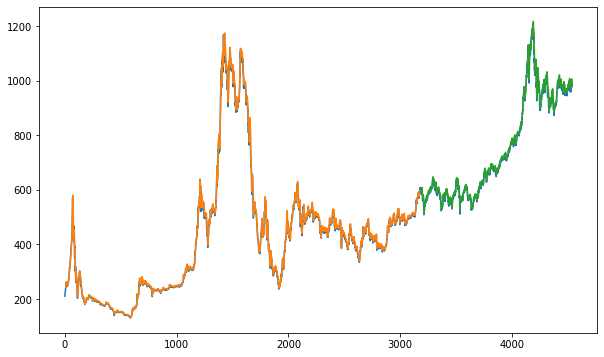

In [103]:
# create and fit Multilayer Perceptron model
model = Sequential()
model.add(Dense(2000, input_dim=look_back, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=20, batch_size=2, verbose=2)
# Estimate model performance
trainScore = model.evaluate(trainX, trainY, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(testX, testY, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))
# generate predictions for training
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(dataset)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()